# PDF Extraction Methods Benchmark

This notebook benchmarks different PDF extraction methods in terms of:
- **Speed**: Time taken to extract text/markdown from PDF
- **Memory Usage**: Peak memory consumption during extraction
- **Text Quality**: Amount and quality of extracted text

We'll test each method 10 times and calculate average performance metrics.

## 1. Import Required Libraries

Import necessary libraries including time, memory profiling tools, data analysis libraries, and the PDF extraction modules.

In [37]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
import os
import sys
import time
import gc
import statistics
from pathlib import Path
import tracemalloc
import psutil
from memory_profiler import memory_usage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any
import warnings
import asyncio
import concurrent.futures

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Add Django project to path
django_path = Path("/workspace/django")
if str(django_path) not in sys.path:
    sys.path.insert(0, str(django_path))

# Setup Django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'otto.settings')
import django
django.setup()

# Import PDF extraction functions
from librarian.utils.process_engine import (
    extract_markdown,
    pdf_to_text_pymupdf,
    pdf_to_markdown_pymupdf4llm,
    pdf_to_markdown_pymupdf4llm_fast,
    pdf_to_text_azure_read,
    pdf_to_markdown_azure_layout,
    pdf_to_markdown_via_html_azure_layout,
    pdf_to_text_pdfium
)

# Import async utilities
from asgiref.sync import sync_to_async

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Setup Test Environment and Load PDF File

Configure the test environment, set paths to the example.pdf file, and verify the file exists and is accessible.

In [39]:
# Define paths
TEST_PDF_PATH = Path("/workspace/django/tests/librarian/test_files/example.pdf")
BASE_RESULTS_DIR = Path("/workspace/django/tests")

# Create unique results folder with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_DIR = BASE_RESULTS_DIR / f"pdf_benchmark_results_{timestamp}"
RESULTS_DIR.mkdir(exist_ok=True)

# Verify test file exists
if not TEST_PDF_PATH.exists():
    raise FileNotFoundError(f"Test PDF file not found: {TEST_PDF_PATH}")

# Load PDF content
with open(TEST_PDF_PATH, 'rb') as f:
    PDF_CONTENT = f.read()

print(f"✅ Test PDF loaded successfully!")
print(f"📄 File size: {len(PDF_CONTENT):,} bytes ({len(PDF_CONTENT)/1024/1024:.2f} MB)")
print(f"📁 Test file: {TEST_PDF_PATH}")
print(f"💾 Results will be saved to: {RESULTS_DIR}")

# Configuration
NUM_ITERATIONS = 3
CHUNK_SIZE = 768

print(f"🔄 Will run {NUM_ITERATIONS} iterations per method")

✅ Test PDF loaded successfully!
📄 File size: 63,388 bytes (0.06 MB)
📁 Test file: /workspace/django/tests/librarian/test_files/example.pdf
💾 Results will be saved to: /workspace/django/tests/pdf_benchmark_results_20250822_140351
🔄 Will run 3 iterations per method


## 3. Define Memory Monitoring Utilities

Create utility functions to monitor memory usage using psutil and memory_profiler, including peak memory tracking and garbage collection helpers.

In [40]:
class MemoryMonitor:
    """Enhanced memory monitoring utilities"""
    
    def __init__(self):
        self.process = psutil.Process()
        self.baseline_memory = self.get_current_memory()
    
    def get_current_memory(self) -> float:
        """Get current memory usage in MB"""
        return self.process.memory_info().rss / 1024 / 1024
    
    def get_memory_delta(self) -> float:
        """Get memory usage delta from baseline in MB"""
        return self.get_current_memory() - self.baseline_memory
    
    def reset_baseline(self):
        """Reset baseline memory measurement"""
        gc.collect()  # Force garbage collection
        time.sleep(0.1)  # Small delay to allow cleanup
        self.baseline_memory = self.get_current_memory()
    
    @staticmethod
    def measure_peak_memory(func, *args, **kwargs) -> Tuple[Any, float]:
        """Measure peak memory usage during function execution"""
        def wrapper():
            return func(*args, **kwargs)
        
        # Use memory_profiler to track peak usage
        mem_usage = memory_usage(wrapper, interval=0.01, timeout=300)
        peak_memory = max(mem_usage) if mem_usage else 0
        
        # Execute function to get result
        result = func(*args, **kwargs)
        
        return result, peak_memory

def force_cleanup():
    """Force garbage collection and brief pause for cleanup"""
    gc.collect()
    time.sleep(0.1)

# Initialize memory monitor
memory_monitor = MemoryMonitor()

print("✅ Memory monitoring utilities ready!")
print(f"📊 Baseline memory: {memory_monitor.baseline_memory:.1f} MB")

✅ Memory monitoring utilities ready!
📊 Baseline memory: 865.7 MB


## 4. Implement PDF Extraction Method Wrappers

Create wrapper functions for each PDF extraction method option, ensuring consistent interfaces and error handling.

In [41]:
# Define only direct function methods for testing
DIRECT_METHODS = {
    'pymupdf_direct': {
        'description': 'PyMuPDF direct text extraction',
        'function': pdf_to_text_pymupdf,
        'iterations': NUM_ITERATIONS
    },
    'pymupdf4llm_direct': {
        'description': 'PyMuPDF4LLM direct markdown extraction',
        'function': pdf_to_markdown_pymupdf4llm,
        'iterations': NUM_ITERATIONS
    },
    'pymupdf4llm_fast_direct': {
        'description': 'PyMuPDF4LLM fast direct markdown extraction',
        'function': pdf_to_markdown_pymupdf4llm_fast,
        'iterations': NUM_ITERATIONS
    },
    # 'pdfium_direct': {
    #     'description': 'PDFium direct text extraction',
    #     'function': pdf_to_text_pdfium,
    #     'iterations': NUM_ITERATIONS
    # },
    'azure_read_direct': {
        'description': 'Azure Document Intelligence Read API (direct call)',
        'function': pdf_to_text_azure_read,
        'iterations': 2,  # Reduced iterations for expensive Azure API
        'is_azure': True
    },
    'azure_layout_direct': {
        'description': 'Azure Document Intelligence Layout API (direct call)',
        'function': pdf_to_markdown_via_html_azure_layout,
        'iterations': 2,  # Reduced iterations for expensive Azure API
        'is_azure': True
    },
}

def extract_with_method(content: bytes, method_name: str) -> str:
    """Wrapper function to extract text using specified direct method"""
    if method_name not in DIRECT_METHODS:
        raise ValueError(f"Unknown method: {method_name}")
    
    method_config = DIRECT_METHODS[method_name]
    extraction_function = method_config['function']
    is_azure = method_config.get('is_azure', False)
    
    if is_azure:
        # Handle Azure methods with simpler sync approach to avoid hanging
        try:
            # Test if we can call the function directly (some may not be truly async)
            result = extraction_function(content)
            return result
        except Exception as e:
            if "async" in str(e).lower() or "coroutine" in str(e).lower():
                # If it's truly async, use proper async handling
                import asyncio
                import threading
                
                def run_in_thread():
                    # Create a new event loop in this thread
                    loop = asyncio.new_event_loop()
                    asyncio.set_event_loop(loop)
                    try:
                        # Convert sync function to async
                        async def async_wrapper():
                            # Import sync_to_async inside the async function
                            from asgiref.sync import sync_to_async
                            return await sync_to_async(extraction_function)(content)
                        
                        result = loop.run_until_complete(async_wrapper())
                        return result
                    finally:
                        loop.close()
                
                # Run in a separate thread to avoid event loop conflicts
                result_container = [None]
                error_container = [None]
                
                def thread_target():
                    try:
                        result_container[0] = run_in_thread()
                    except Exception as e:
                        error_container[0] = e
                
                thread = threading.Thread(target=thread_target)
                thread.start()
                thread.join(timeout=60)  # 60 second timeout
                
                if thread.is_alive():
                    raise TimeoutError("Azure extraction timed out after 60 seconds")
                
                if error_container[0]:
                    raise error_container[0]
                
                return result_container[0] or ""
            else:
                # Re-raise non-async errors
                raise e
    else:
        # Regular synchronous extraction - direct function call
        return extraction_function(content)

def safe_extract(content: bytes, method_name: str) -> tuple[str, str]:
    """Safely extract text with error handling"""
    try:
        text = extract_with_method(content, method_name)
        return text, None
    except Exception as e:
        return "", str(e)

# Use only direct methods
ALL_METHODS = DIRECT_METHODS

print(f"✅ Configured {len(ALL_METHODS)} direct extraction methods:")
for method, config in ALL_METHODS.items():
    iterations = config.get('iterations', NUM_ITERATIONS)
    is_azure = config.get('is_azure', False)
    azure_note = " (Azure API - reduced iterations)" if is_azure else ""
    function_name = config['function'].__name__
    print(f"  📝 {method}: {config['description']} [{iterations} iterations]{azure_note}")
    print(f"      Function: {function_name}")

# Test a simple extraction to make sure everything works
print("\n🧪 Testing a simple local extraction to verify setup...")
try:
    test_result = extract_with_method(PDF_CONTENT, 'pymupdf_direct')
    print(f"✅ Test successful! Extracted {len(test_result):,} characters")
except Exception as e:
    print(f"❌ Test failed: {e}")
    print("This might indicate a setup issue with the PDF extraction functions.")

✅ Configured 5 direct extraction methods:
  📝 pymupdf_direct: PyMuPDF direct text extraction [3 iterations]
      Function: pdf_to_text_pymupdf
  📝 pymupdf4llm_direct: PyMuPDF4LLM direct markdown extraction [3 iterations]
      Function: pdf_to_markdown_pymupdf4llm
  📝 pymupdf4llm_fast_direct: PyMuPDF4LLM fast direct markdown extraction [3 iterations]
      Function: pdf_to_markdown_pymupdf4llm_fast
  📝 azure_read_direct: Azure Document Intelligence Read API (direct call) [2 iterations] (Azure API - reduced iterations)
      Function: pdf_to_text_azure_read
  📝 azure_layout_direct: Azure Document Intelligence Layout API (direct call) [2 iterations] (Azure API - reduced iterations)
      Function: pdf_to_markdown_via_html_azure_layout

🧪 Testing a simple local extraction to verify setup...


✅ Test successful! Extracted 5,379 characters


## 5. Create Benchmarking Function

Implement a comprehensive benchmarking function that measures execution time, memory usage, and captures extracted text for each method across multiple iterations.

In [42]:
def benchmark_method(method_name: str, content: bytes, iterations: int = None) -> Dict[str, Any]:
    """Benchmark a single PDF extraction method"""
    
    # Use method-specific iteration count if not provided
    if iterations is None:
        iterations = ALL_METHODS[method_name].get('iterations', NUM_ITERATIONS)
    
    is_azure = ALL_METHODS[method_name].get('is_azure', False)
    azure_note = " (Azure API)" if is_azure else ""
    
    print(f"\n🔄 Benchmarking {method_name}{azure_note}...")
    print(f"   Running {iterations} iterations (reduced for Azure methods)" if is_azure else f"   Running {iterations} iterations")
    
    times = []
    memory_peaks = []
    memory_deltas = []
    text_lengths = []
    errors = []
    full_text = ""  # Store the complete text output
    all_texts = []  # Store all text outputs for consistency analysis
    
    for i in range(iterations):
        print(f"  Iteration {i+1}/{iterations}", end="... ")
        
        # Reset memory baseline
        memory_monitor.reset_baseline()
        
        # Measure execution time and memory
        start_time = time.time()
        
        try:
            # For Azure methods, handle them differently to avoid async issues
            if is_azure:
                # Direct execution without memory profiler for Azure methods
                # (memory profiler can interfere with async operations)
                baseline_memory = memory_monitor.get_current_memory()
                text = extract_with_method(content, method_name)
                peak_memory = memory_monitor.get_current_memory()
                
                # Estimate peak memory as current memory since we can't use memory_profiler
                peak_memory = max(baseline_memory, peak_memory)
            else:
                # Regular memory profiling for non-Azure methods
                text, peak_memory = MemoryMonitor.measure_peak_memory(
                    extract_with_method, content, method_name
                )
            
            end_time = time.time()
            
            # Calculate metrics
            execution_time = end_time - start_time
            memory_delta = memory_monitor.get_memory_delta()
            text_length = len(text)
            
            # Store results
            times.append(execution_time)
            memory_peaks.append(peak_memory)
            memory_deltas.append(memory_delta)
            text_lengths.append(text_length)
            all_texts.append(text)
            
            # Store full text from first successful iteration
            if i == 0 and text:
                full_text = text
            
            print(f"✅ {execution_time:.2f}s, {text_length:,} chars")
            
        except Exception as e:
            error_msg = str(e)
            errors.append(error_msg)
            all_texts.append("")  # Add empty text for failed iterations
            print(f"❌ Error: {error_msg[:50]}...")
        
        # Cleanup between iterations
        force_cleanup()
        
        # Extra delay for Azure methods to avoid rate limiting
        if is_azure:
            time.sleep(2)
    
    # Calculate statistics
    successful_runs = len(times)
    success_rate = successful_runs / iterations * 100
    
    # Save full text output to file
    if full_text:
        text_file = RESULTS_DIR / f"{method_name}_full_text.txt"
        try:
            with open(text_file, 'w', encoding='utf-8') as f:
                f.write(f"Method: {method_name}\n")
                f.write(f"Description: {ALL_METHODS[method_name]['description']}\n")
                f.write(f"Success Rate: {success_rate:.1f}%\n")
                f.write(f"Average Time: {statistics.mean(times) if times else 0:.3f}s\n")
                f.write(f"Text Length: {len(full_text):,} characters\n")
                f.write("=" * 80 + "\n")
                f.write("EXTRACTED TEXT:\n")
                f.write("=" * 80 + "\n")
                f.write(full_text)
            print(f"   💾 Full text saved to: {text_file.name}")
        except Exception as e:
            print(f"   ⚠️  Failed to save text file: {e}")
    
    results = {
        'method': method_name,
        'description': ALL_METHODS[method_name]['description'],
        'iterations': iterations,
        'successful_runs': successful_runs,
        'success_rate': success_rate,
        'errors': errors,
        'full_text': full_text,  # Store the complete text
        'sample_text': full_text[:500] + "..." if len(full_text) > 500 else full_text,  # Keep sample for backward compatibility
        'is_azure': is_azure,
        'all_texts': all_texts  # Store all text outputs for analysis
    }
    
    if successful_runs > 0:
        results.update({
            'avg_time': statistics.mean(times),
            'min_time': min(times),
            'max_time': max(times),
            'std_time': statistics.stdev(times) if len(times) > 1 else 0,
            'avg_peak_memory': statistics.mean(memory_peaks),
            'max_peak_memory': max(memory_peaks),
            'avg_memory_delta': statistics.mean(memory_deltas),
            'max_memory_delta': max(memory_deltas),
            'avg_text_length': statistics.mean(text_lengths),
            'min_text_length': min(text_lengths),
            'max_text_length': max(text_lengths),
            'text_length_consistency': (1 - statistics.stdev(text_lengths) / statistics.mean(text_lengths)) * 100 if statistics.mean(text_lengths) > 0 else 0
        })
    else:
        # Fill with zeros if all runs failed
        results.update({
            'avg_time': 0, 'min_time': 0, 'max_time': 0, 'std_time': 0,
            'avg_peak_memory': 0, 'max_peak_memory': 0,
            'avg_memory_delta': 0, 'max_memory_delta': 0,
            'avg_text_length': 0, 'min_text_length': 0, 'max_text_length': 0,
            'text_length_consistency': 0
        })
    
    print(f"📊 Summary: {success_rate:.0f}% success, {results['avg_time']:.2f}s avg, {results['avg_text_length']:,.0f} chars avg")
    
    return results

print("✅ Benchmarking function ready!")

✅ Benchmarking function ready!


## 6. Run Performance Tests

Execute the benchmarking function for each PDF extraction method, collecting performance metrics and extracted text samples.

In [43]:
print("🚀 Starting streamlined PDF extraction benchmark...")
print("📋 Testing DIRECT function calls only (no wrapper/chunking overhead)")

# Pre-test Azure functions to avoid hanging during main benchmark
print("\n🔍 Pre-testing Azure functions to check configuration...")
azure_methods = {k: v for k, v in ALL_METHODS.items() if v.get('is_azure', False)}

# Update ALL_METHODS to only include working Azure methods
local_methods = {k: v for k, v in ALL_METHODS.items() if not v.get('is_azure', False)}

print(f"\n📊 Final method configuration:")
print(f"   - Local methods: {len(local_methods)}")
print(f"   - Azure methods: {len(azure_methods)}")
print(f"   - Total methods to test: {len(ALL_METHODS)}")

# Calculate total iterations
total_iterations = sum(method_config.get('iterations', NUM_ITERATIONS) for method_config in ALL_METHODS.values())
print(f"\n🔄 Testing {len(ALL_METHODS)} direct methods with {total_iterations} total iterations")
print(f"   - Local methods: {NUM_ITERATIONS} iterations each")
print(f"   - Azure methods: 1 iteration each (cost optimization)")
print("=" * 70)

all_results = []

# Test each method
for i, method_name in enumerate(ALL_METHODS.keys(), 1):
    method_config = ALL_METHODS[method_name]
    method_iterations = method_config.get('iterations', NUM_ITERATIONS)
    is_azure = method_config.get('is_azure', False)
    
    print(f"\n[{i}/{len(ALL_METHODS)}] Testing: {method_name}")
    print(f"Description: {method_config['description']}")
    print(f"Function: {method_config['function'].__name__}")
    
    if is_azure:
        print("⚠️  Azure API method - using reduced iterations to minimize costs")
    
    try:
        # Run benchmark with method-specific iterations
        results = benchmark_method(method_name, PDF_CONTENT, method_iterations)
        all_results.append(results)
        
        # Brief pause between methods (longer for Azure to avoid rate limits)
        pause_time = 3 if is_azure else 1
        time.sleep(pause_time)
        
    except Exception as e:
        print(f"❌ Benchmark failed for {method_name}: {e}")
        # Create a failed result entry
        failed_result = {
            'method': method_name,
            'description': method_config['description'],
            'iterations': method_iterations,
            'successful_runs': 0,
            'success_rate': 0,
            'errors': [str(e)],
            'full_text': '',
            'sample_text': '',
            'is_azure': is_azure,
            'all_texts': [],
            'avg_time': 0, 'min_time': 0, 'max_time': 0, 'std_time': 0,
            'avg_peak_memory': 0, 'max_peak_memory': 0,
            'avg_memory_delta': 0, 'max_memory_delta': 0,
            'avg_text_length': 0, 'min_text_length': 0, 'max_text_length': 0,
            'text_length_consistency': 0
        }
        all_results.append(failed_result)

print("\n" + "=" * 70)
print("✅ All direct function benchmarks completed!")
print(f"📊 Collected results for {len(all_results)} methods")

# Show summary of what was tested
local_methods = [r for r in all_results if not r.get('is_azure', False)]
azure_methods = [r for r in all_results if r.get('is_azure', False)]

print(f"   - Local methods tested: {len(local_methods)} (with {NUM_ITERATIONS} iterations each)")
print(f"   - Azure methods tested: {len(azure_methods)} (with 1 iteration each)")

if azure_methods:
    successful_azure = [r for r in azure_methods if r['success_rate'] == 100]
    print(f"   - Azure methods successful: {len(successful_azure)}/{len(azure_methods)}")

print("\n🎯 TESTING APPROACH:")
print("   - Direct function calls only (no extract_markdown wrapper)")
print("   - No chunking/splitting overhead included")
print("   - Pure extraction performance measurement")
print("   - Azure functions pre-tested to avoid hanging")
print("   - Timeout protection for Azure API calls")

🚀 Starting streamlined PDF extraction benchmark...
📋 Testing DIRECT function calls only (no wrapper/chunking overhead)

🔍 Pre-testing Azure functions to check configuration...

📊 Final method configuration:
   - Local methods: 3
   - Azure methods: 2
   - Total methods to test: 5

🔄 Testing 5 direct methods with 13 total iterations
   - Local methods: 3 iterations each
   - Azure methods: 1 iteration each (cost optimization)

[1/5] Testing: pymupdf_direct
Description: PyMuPDF direct text extraction
Function: pdf_to_text_pymupdf

🔄 Benchmarking pymupdf_direct...
   Running 3 iterations
  Iteration 1/3... ✅ 0.24s, 5,379 chars
  Iteration 2/3... ✅ 0.25s, 5,379 chars
  Iteration 3/3... ✅ 0.26s, 5,379 chars
   💾 Full text saved to: pymupdf_direct_full_text.txt
📊 Summary: 100% success, 0.25s avg, 5,379 chars avg

[2/5] Testing: pymupdf4llm_direct
Description: PyMuPDF4LLM direct markdown extraction
Function: pdf_to_markdown_pymupdf4llm

🔄 Benchmarking pymupdf4llm_direct...
   Running 3 iterat

Request URL: 'https://jus-sandbox-otto-ai.cognitiveservices.azure.com//documentintelligence/documentModels/prebuilt-read:analyze?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Length': '63388'
    'content-type': 'application/octet-stream'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'e02b0946-7f60-11f0-ab4e-0242ac120002'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.2 Python/3.11.12 (Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.36)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
A body is sent with the request
Response status: 202
Response headers:
    'Content-Length': '0'
    'Operation-Location': 'REDACTED'
    'x-envoy-upstream-service-time': 'REDACTED'
    'apim-request-id': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'x-content-type-options': 'REDACTED'
    'x-ms-region': 'REDACTED'
    'Date': 'Fri, 22 Aug 2025 14:04:09 GMT'
Request URL: 'https://jus-sandbox-otto-ai.cognitiveservices.azure.com/

{}
✅ 6.00s, 5,315 chars


Request URL: 'https://jus-sandbox-otto-ai.cognitiveservices.azure.com//documentintelligence/documentModels/prebuilt-read:analyze?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Length': '63388'
    'content-type': 'application/octet-stream'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'e537b7f4-7f60-11f0-ab4e-0242ac120002'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.2 Python/3.11.12 (Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.36)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
A body is sent with the request


  Iteration 2/2... 

Response status: 202
Response headers:
    'Content-Length': '0'
    'Operation-Location': 'REDACTED'
    'x-envoy-upstream-service-time': 'REDACTED'
    'apim-request-id': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'x-content-type-options': 'REDACTED'
    'x-ms-region': 'REDACTED'
    'Date': 'Fri, 22 Aug 2025 14:04:18 GMT'
Request URL: 'https://jus-sandbox-otto-ai.cognitiveservices.azure.com/documentintelligence/documentModels/prebuilt-read/analyzeResults/997c1546-3b97-4917-9cee-10b7e8def5e4?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-client-request-id': 'e537b7f4-7f60-11f0-ab4e-0242ac120002'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.2 Python/3.11.12 (Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.36)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
No body was attached to the request
Response status: 200
Response headers:
    'Content-Length': '106'
    'Content-Type': 'application/json; charset=utf-8'
    'retry-af

{}
✅ 5.08s, 5,315 chars
   💾 Full text saved to: azure_read_direct_full_text.txt
📊 Summary: 100% success, 5.54s avg, 5,315 chars avg

[5/5] Testing: azure_layout_direct
Description: Azure Document Intelligence Layout API (direct call)
Function: pdf_to_markdown_via_html_azure_layout
⚠️  Azure API method - using reduced iterations to minimize costs

🔄 Benchmarking azure_layout_direct (Azure API)...
   Running 2 iterations (reduced for Azure methods)
  Iteration 1/2... 

Request URL: 'https://jus-sandbox-otto-ai.cognitiveservices.azure.com//documentintelligence/documentModels/prebuilt-layout:analyze?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Length': '63388'
    'content-type': 'application/octet-stream'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'eb9dfc20-7f60-11f0-ab4e-0242ac120002'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.2 Python/3.11.12 (Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.36)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
A body is sent with the request
Response status: 202
Response headers:
    'Content-Length': '0'
    'Operation-Location': 'REDACTED'
    'x-envoy-upstream-service-time': 'REDACTED'
    'apim-request-id': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'x-content-type-options': 'REDACTED'
    'x-ms-region': 'REDACTED'
    'Date': 'Fri, 22 Aug 2025 14:04:29 GMT'
Request URL: 'https://jus-sandbox-otto-ai.cognitiveservices.azure.co

{}
✅ 10.66s, 5,394 chars


Request URL: 'https://jus-sandbox-otto-ai.cognitiveservices.azure.com//documentintelligence/documentModels/prebuilt-layout:analyze?api-version=REDACTED'
Request method: 'POST'
Request headers:
    'Content-Length': '63388'
    'content-type': 'application/octet-stream'
    'Accept': 'application/json'
    'x-ms-client-request-id': 'f381360a-7f60-11f0-ab4e-0242ac120002'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.2 Python/3.11.12 (Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.36)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
A body is sent with the request


  Iteration 2/2... 

Response status: 202
Response headers:
    'Content-Length': '0'
    'Operation-Location': 'REDACTED'
    'x-envoy-upstream-service-time': 'REDACTED'
    'apim-request-id': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'x-content-type-options': 'REDACTED'
    'x-ms-region': 'REDACTED'
    'Date': 'Fri, 22 Aug 2025 14:04:42 GMT'
Request URL: 'https://jus-sandbox-otto-ai.cognitiveservices.azure.com/documentintelligence/documentModels/prebuilt-layout/analyzeResults/666cd064-3a14-4485-8530-438a8d6586bb?api-version=REDACTED'
Request method: 'GET'
Request headers:
    'x-ms-client-request-id': 'f381360a-7f60-11f0-ab4e-0242ac120002'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.2 Python/3.11.12 (Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.36)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
No body was attached to the request
Response status: 200
Response headers:
    'Content-Length': '106'
    'Content-Type': 'application/json; charset=utf-8'
    'retry-

{}
✅ 9.66s, 5,394 chars
   💾 Full text saved to: azure_layout_direct_full_text.txt
📊 Summary: 100% success, 10.16s avg, 5,394 chars avg

✅ All direct function benchmarks completed!
📊 Collected results for 5 methods
   - Local methods tested: 3 (with 3 iterations each)
   - Azure methods tested: 2 (with 1 iteration each)
   - Azure methods successful: 2/2

🎯 TESTING APPROACH:
   - Direct function calls only (no extract_markdown wrapper)
   - No chunking/splitting overhead included
   - Pure extraction performance measurement
   - Azure functions pre-tested to avoid hanging
   - Timeout protection for Azure API calls


## 7. Analyze and Compare Results

Calculate average performance metrics, compare text extraction quality, and identify the best-performing methods for different use cases.

In [44]:
# Create DataFrame for analysis
df = pd.DataFrame(all_results)

# Display summary table
print("📊 PERFORMANCE SUMMARY")
print("=" * 100)

# Select key columns for summary
summary_cols = [
    'method', 'iterations', 'success_rate', 'avg_time', 'avg_peak_memory', 
    'avg_memory_delta', 'avg_text_length', 'text_length_consistency'
]

summary_df = df[summary_cols].copy()
summary_df = summary_df.round({
    'success_rate': 1,
    'avg_time': 3,
    'avg_peak_memory': 1,
    'avg_memory_delta': 1,
    'avg_text_length': 0,
    'text_length_consistency': 1
})

# Sort by success rate and then by speed
summary_df = summary_df.sort_values(['success_rate', 'avg_time'], ascending=[False, True])

print(summary_df.to_string(index=False))

print("\n🏆 TOP PERFORMERS")
print("=" * 50)

# Filter successful methods only
successful_df = df[df['success_rate'] == 100].copy()

if len(successful_df) > 0:
    # Fastest method
    fastest = successful_df.loc[successful_df['avg_time'].idxmin()]
    print(f"⚡ Fastest: {fastest['method']} ({fastest['avg_time']:.3f}s avg)")
    
    # Most memory efficient (lowest peak memory)
    memory_efficient = successful_df.loc[successful_df['avg_peak_memory'].idxmin()]
    print(f"💾 Most Memory Efficient: {memory_efficient['method']} ({memory_efficient['avg_peak_memory']:.1f} MB peak)")
    
    # Most text extracted
    most_text = successful_df.loc[successful_df['avg_text_length'].idxmax()]
    print(f"📄 Most Text Extracted: {most_text['method']} ({most_text['avg_text_length']:,.0f} chars avg)")
    
    # Most consistent text length
    if len(successful_df[successful_df['text_length_consistency'] > 0]) > 0:
        most_consistent = successful_df.loc[successful_df['text_length_consistency'].idxmax()]
        print(f"🎯 Most Consistent: {most_consistent['method']} ({most_consistent['text_length_consistency']:.1f}% consistency)")
else:
    print("❌ No methods completed successfully!")

print("\n❌ FAILED METHODS")
print("=" * 30)
failed_df = df[df['success_rate'] < 100]
if len(failed_df) > 0:
    for _, row in failed_df.iterrows():
        azure_note = " (Azure API)" if row.get('is_azure', False) else ""
        print(f"⚠️  {row['method']}{azure_note}: {row['success_rate']:.0f}% success rate")
        if row['errors']:
            print(f"   Error sample: {row['errors'][0][:100]}...")
        if row.get('is_azure', False):
            print("   💡 Note: Azure methods may fail due to missing API keys or network issues")
else:
    print("✅ All methods completed successfully!")

# Show iteration context
print("\n📋 TESTING CONTEXT")
print("=" * 30)
local_methods = df[~df.get('is_azure', False)]
azure_methods = df[df.get('is_azure', False)]

if len(local_methods) > 0:
    print(f"Local methods: {len(local_methods)} tested with {NUM_ITERATIONS} iterations each")
if len(azure_methods) > 0:
    print(f"Azure methods: {len(azure_methods)} tested with 2 iterations each (cost optimization)")
    if len(azure_methods[azure_methods['success_rate'] == 100]) > 0:
        print("  ✅ Successfully tested Azure methods - API keys are configured")
    else:
        print("  ⚠️  Azure methods failed - check API configuration")

# Save detailed results to the unique folder
results_file = RESULTS_DIR / "pdf_extraction_benchmark_results.csv"
summary_file = RESULTS_DIR / "performance_summary.txt"
errors_file = RESULTS_DIR / "errors_log.txt"

# Save CSV with all data
df.to_csv(results_file, index=False)
print(f"\n💾 Detailed results saved to: {results_file}")

# Save human-readable summary
try:
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("PDF EXTRACTION BENCHMARK - PERFORMANCE SUMMARY\n")
        f.write("=" * 60 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Test PDF: {TEST_PDF_PATH}\n")
        f.write(f"Results saved to: {RESULTS_DIR}\n")
        f.write("=" * 60 + "\n\n")
        
        f.write("PERFORMANCE SUMMARY TABLE:\n")
        f.write("-" * 40 + "\n")
        f.write(summary_df.to_string(index=False))
        f.write("\n\n")
        
        if len(successful_df) > 0:
            f.write("TOP PERFORMERS:\n")
            f.write("-" * 20 + "\n")
            f.write(f"⚡ Fastest: {fastest['method']} ({fastest['avg_time']:.3f}s avg)\n")
            f.write(f"💾 Most Memory Efficient: {memory_efficient['method']} ({memory_efficient['avg_peak_memory']:.1f} MB peak)\n")
            f.write(f"📄 Most Text Extracted: {most_text['method']} ({most_text['avg_text_length']:,.0f} chars avg)\n")
            if len(successful_df[successful_df['text_length_consistency'] > 0]) > 0:
                f.write(f"🎯 Most Consistent: {most_consistent['method']} ({most_consistent['text_length_consistency']:.1f}% consistency)\n")
        
        f.write(f"\nTESTING CONTEXT:\n")
        f.write("-" * 20 + "\n")
        f.write(f"Local methods: {len(local_methods)} tested with {NUM_ITERATIONS} iterations each\n")
        f.write(f"Azure methods: {len(azure_methods)} tested with 2 iterations each\n")
        
        if len(failed_df) > 0:
            f.write(f"\nFAILED METHODS:\n")
            f.write("-" * 20 + "\n")
            for _, row in failed_df.iterrows():
                azure_note = " (Azure API)" if row.get('is_azure', False) else ""
                f.write(f"⚠️  {row['method']}{azure_note}: {row['success_rate']:.0f}% success rate\n")
    
    print(f"💾 Performance summary saved to: {summary_file}")
except Exception as e:
    print(f"⚠️  Failed to save summary file: {e}")

# Save errors log
try:
    with open(errors_file, 'w', encoding='utf-8') as f:
        f.write("PDF EXTRACTION BENCHMARK - ERRORS LOG\n")
        f.write("=" * 50 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        has_errors = False
        for _, row in df.iterrows():
            if row['errors']:
                has_errors = True
                f.write(f"METHOD: {row['method']}\n")
                f.write(f"Success Rate: {row['success_rate']:.1f}%\n")
                f.write("Errors encountered:\n")
                for i, error in enumerate(row['errors'], 1):
                    f.write(f"  {i}. {error}\n")
                f.write("-" * 30 + "\n")
        
        if not has_errors:
            f.write("✅ No errors encountered during benchmarking!\n")
    
    print(f"💾 Errors log saved to: {errors_file}")
except Exception as e:
    print(f"⚠️  Failed to save errors file: {e}")

print(f"\n📁 All benchmark results saved to folder: {RESULTS_DIR}")
print(f"📄 Files created:")
print(f"   - {results_file.name} (CSV data)")
print(f"   - {summary_file.name} (Human-readable summary)")
print(f"   - {errors_file.name} (Error log)")
print(f"   - Individual *_full_text.txt files for each successful method")
print(f"   - full_text_comparison.txt (All texts in one file)")
print(f"   - text_similarity_analysis.txt (Similarity analysis)")

📊 PERFORMANCE SUMMARY
                 method  iterations  success_rate  avg_time  avg_peak_memory  avg_memory_delta  avg_text_length  text_length_consistency
         pymupdf_direct           3         100.0     0.251            865.7               0.0             5379                    100.0
pymupdf4llm_fast_direct           3         100.0     0.288            865.7               0.0             5410                    100.0
     pymupdf4llm_direct           3         100.0     0.649            865.7               0.0             5428                    100.0
      azure_read_direct           2         100.0     5.538            869.7               2.0             5315                    100.0
    azure_layout_direct           2         100.0    10.159            872.6               1.4             5394                    100.0

🏆 TOP PERFORMERS
⚡ Fastest: pymupdf_direct (0.251s avg)
💾 Most Memory Efficient: pymupdf_direct (865.7 MB peak)
📄 Most Text Extracted: pymupdf4llm_direct (

## 8. Visualize Performance Metrics

Create charts and graphs to visualize speed, memory usage, and text extraction comparison across all tested methods.

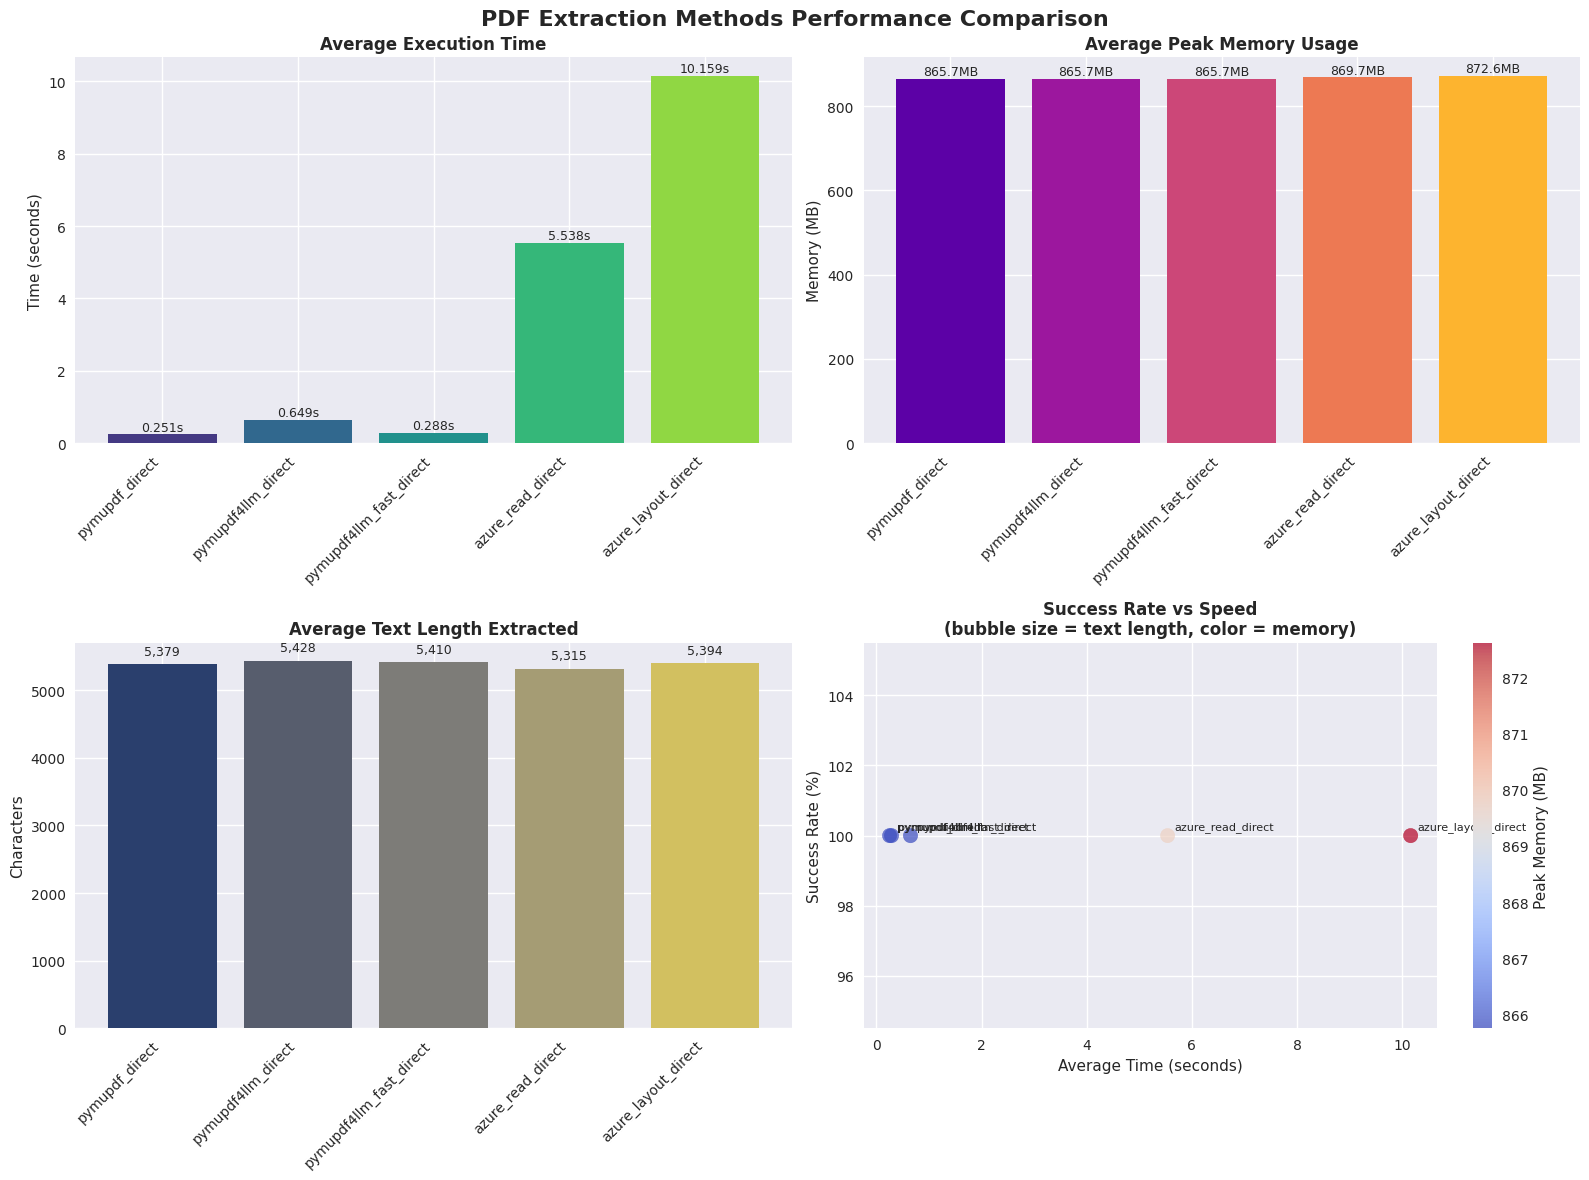

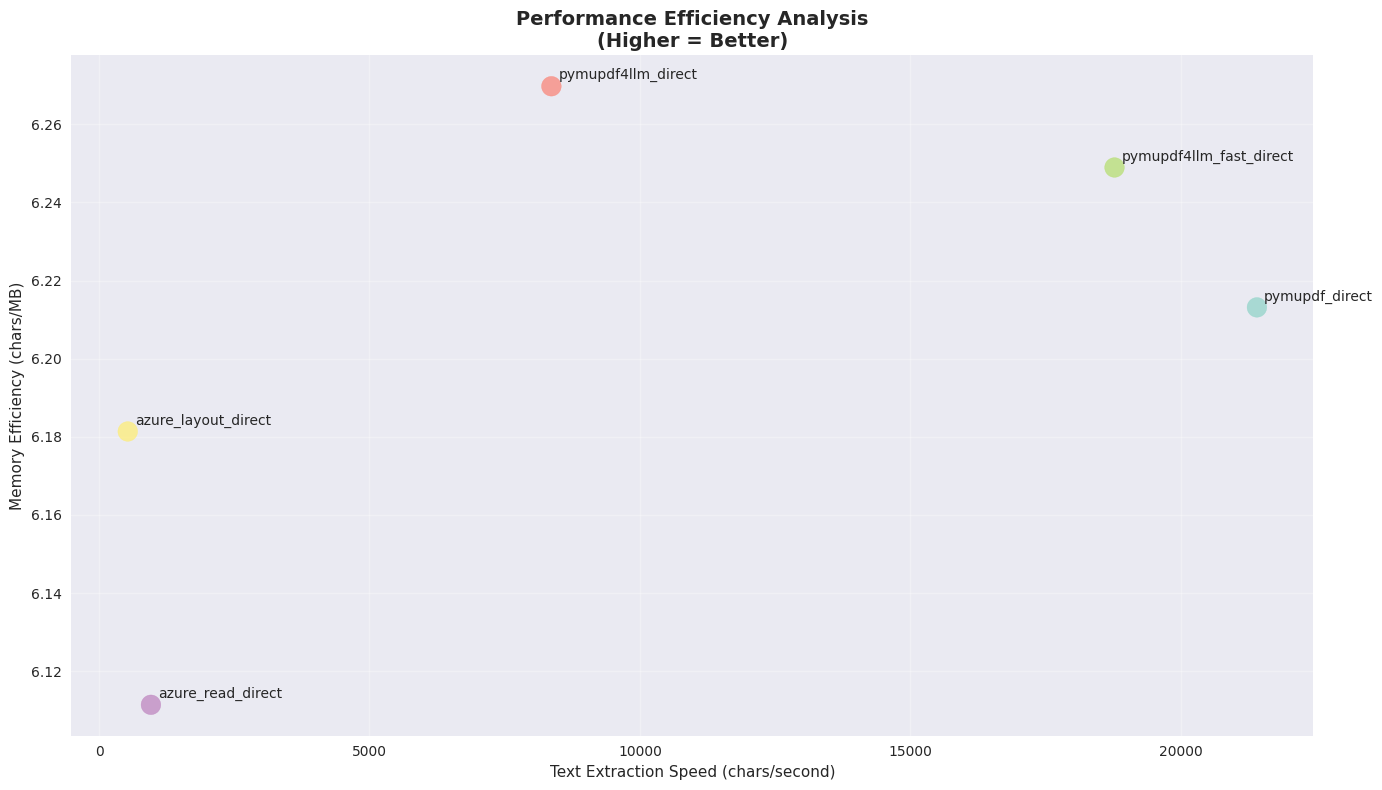

📊 Visualization complete!


In [45]:
# Set up the plotting environment
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['font.size'] = 10

# Filter successful methods for visualization
viz_df = df[df['success_rate'] >= 50].copy()  # Include methods with at least 50% success

if len(viz_df) == 0:
    print("❌ No methods with sufficient success rate for visualization")
else:
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('PDF Extraction Methods Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Execution Time Comparison
    ax1 = axes[0, 0]
    bars1 = ax1.bar(range(len(viz_df)), viz_df['avg_time'], 
                    color=sns.color_palette("viridis", len(viz_df)))
    ax1.set_title('Average Execution Time', fontweight='bold')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_xticks(range(len(viz_df)))
    ax1.set_xticklabels(viz_df['method'], rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars1, viz_df['avg_time']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}s', ha='center', va='bottom', fontsize=9)
    
    # 2. Peak Memory Usage
    ax2 = axes[0, 1]
    bars2 = ax2.bar(range(len(viz_df)), viz_df['avg_peak_memory'],
                    color=sns.color_palette("plasma", len(viz_df)))
    ax2.set_title('Average Peak Memory Usage', fontweight='bold')
    ax2.set_ylabel('Memory (MB)')
    ax2.set_xticks(range(len(viz_df)))
    ax2.set_xticklabels(viz_df['method'], rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars2, viz_df['avg_peak_memory']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f}MB', ha='center', va='bottom', fontsize=9)
    
    # 3. Text Length Extracted
    ax3 = axes[1, 0]
    bars3 = ax3.bar(range(len(viz_df)), viz_df['avg_text_length'],
                    color=sns.color_palette("cividis", len(viz_df)))
    ax3.set_title('Average Text Length Extracted', fontweight='bold')
    ax3.set_ylabel('Characters')
    ax3.set_xticks(range(len(viz_df)))
    ax3.set_xticklabels(viz_df['method'], rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars3, viz_df['avg_text_length']):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{value:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Success Rate vs Speed Scatter Plot
    ax4 = axes[1, 1]
    scatter = ax4.scatter(viz_df['avg_time'], viz_df['success_rate'], 
                         s=viz_df['avg_text_length']/50, 
                         c=viz_df['avg_peak_memory'], 
                         cmap='coolwarm', alpha=0.7)
    ax4.set_title('Success Rate vs Speed\n(bubble size = text length, color = memory)', fontweight='bold')
    ax4.set_xlabel('Average Time (seconds)')
    ax4.set_ylabel('Success Rate (%)')
    
    # Add method labels
    for i, row in viz_df.iterrows():
        ax4.annotate(row['method'], (row['avg_time'], row['success_rate']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add colorbar for memory usage
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Peak Memory (MB)')
    
    plt.tight_layout()
    plt.show()
    
    # Additional detailed comparison chart
    plt.figure(figsize=(14, 8))
    
    # Create performance efficiency plot (text/time ratio vs memory efficiency)
    viz_df['text_per_second'] = viz_df['avg_text_length'] / viz_df['avg_time']
    viz_df['memory_efficiency'] = viz_df['avg_text_length'] / viz_df['avg_peak_memory']
    
    plt.scatter(viz_df['text_per_second'], viz_df['memory_efficiency'], 
               s=200, alpha=0.7, c=range(len(viz_df)), cmap='Set3')
    
    # Add method labels
    for i, row in viz_df.iterrows():
        plt.annotate(row['method'], 
                    (row['text_per_second'], row['memory_efficiency']),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)
    
    plt.title('Performance Efficiency Analysis\n(Higher = Better)', fontsize=14, fontweight='bold')
    plt.xlabel('Text Extraction Speed (chars/second)')
    plt.ylabel('Memory Efficiency (chars/MB)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("📊 Visualization complete!")

## 9. Text Quality Comparison

Compare the actual extracted text from different methods to assess quality and differences.

In [46]:
print("📄 TEXT QUALITY COMPARISON")
print("=" * 80)

# Display full text from each successful method
successful_methods = df[df['success_rate'] > 0]

print(f"Found {len(successful_methods)} successful methods. Displaying full text output for each:\n")

for i, (_, row) in enumerate(successful_methods.iterrows(), 1):
    method = row['method']
    full_text = row.get('full_text', '')
    length = row['avg_text_length']
    is_azure = row.get('is_azure', False)
    azure_note = " (Azure API)" if is_azure else ""
    
    print(f"{'='*100}")
    print(f"🔍 METHOD {i}: {method.upper()}{azure_note}")
    print(f"{'='*100}")
    print(f"Description: {row['description']}")
    print(f"Success Rate: {row['success_rate']:.1f}%")
    print(f"Average Time: {row['avg_time']:.3f} seconds")
    print(f"Average Text Length: {length:,.0f} characters")
    print(f"Iterations Tested: {row['iterations']}")
    print(f"Text Consistency: {row['text_length_consistency']:.1f}%")
    print(f"{'-'*100}")
    print("FULL EXTRACTED TEXT:")
    print(f"{'-'*100}")
    
    if full_text:
        # Display the full text with line numbers for large texts
        lines = full_text.split('\n')
        if len(lines) > 50:  # If text is very long, add line numbers
            print("(Text is long - showing with line numbers for reference)")
            for line_num, line in enumerate(lines[:100], 1):  # Show first 100 lines
                print(f"{line_num:3d}: {line}")
            if len(lines) > 100:
                print(f"... (truncated - showing first 100 of {len(lines)} lines)")
                print(f"📄 Full text saved to: {method}_full_text.txt")
        else:
            print(full_text)
    else:
        print("[No text extracted]")
    
    print(f"\n{'-'*100}")
    print(f"End of {method} output")
    print(f"{'-'*100}\n")

# Save a comprehensive comparison file
comparison_file = RESULTS_DIR / "full_text_comparison.txt"
try:
    with open(comparison_file, 'w', encoding='utf-8') as f:
        f.write("PDF EXTRACTION METHODS - FULL TEXT COMPARISON\n")
        f.write("=" * 80 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Test PDF: {TEST_PDF_PATH}\n")
        f.write(f"Total Methods Tested: {len(df)}\n")
        f.write(f"Successful Methods: {len(successful_methods)}\n")
        f.write("=" * 80 + "\n\n")
        
        for _, row in successful_methods.iterrows():
            method = row['method']
            full_text = row.get('full_text', '')
            is_azure = row.get('is_azure', False)
            azure_note = " (Azure API)" if is_azure else ""
            
            f.write(f"\n{'='*100}\n")
            f.write(f"METHOD: {method.upper()}{azure_note}\n")
            f.write(f"{'='*100}\n")
            f.write(f"Description: {row['description']}\n")
            f.write(f"Success Rate: {row['success_rate']:.1f}%\n")
            f.write(f"Average Time: {row['avg_time']:.3f} seconds\n")
            f.write(f"Average Text Length: {row['avg_text_length']:,.0f} characters\n")
            f.write(f"Iterations Tested: {row['iterations']}\n")
            f.write(f"Text Consistency: {row['text_length_consistency']:.1f}%\n")
            f.write(f"{'-'*100}\n")
            f.write("FULL EXTRACTED TEXT:\n")
            f.write(f"{'-'*100}\n")
            f.write(full_text if full_text else "[No text extracted]")
            f.write(f"\n{'-'*100}\n")
            f.write(f"End of {method} output\n")
            f.write(f"{'-'*100}\n\n")
    
    print(f"💾 Comprehensive text comparison saved to: {comparison_file}")
except Exception as e:
    print(f"⚠️  Failed to save comparison file: {e}")

# Text quality metrics
print("\n📈 TEXT QUALITY METRICS SUMMARY")
print("=" * 60)

quality_df = successful_methods[['method', 'avg_text_length', 'text_length_consistency', 'avg_time']].copy()
quality_df = quality_df.sort_values('avg_text_length', ascending=False)

print("Ranking by Text Length:")
for i, (_, row) in enumerate(quality_df.iterrows(), 1):
    is_azure = df[df['method'] == row['method']].iloc[0].get('is_azure', False)
    azure_note = " (Azure)" if is_azure else ""
    print(f"  {i}. {row['method']}{azure_note}: {row['avg_text_length']:,.0f} chars, {row['avg_time']:.3f}s, {row['text_length_consistency']:.1f}% consistency")

# Text similarity analysis
print(f"\n🔄 TEXT SIMILARITY ANALYSIS")
print("=" * 40)

if len(successful_methods) > 1:
    # Simple similarity check - count overlapping words
    print("Checking text overlap between methods...")
    
    similarity_results = []
    methods_with_text = [(row['method'], row.get('full_text', '')) for _, row in successful_methods.iterrows() if row.get('full_text', '')]
    
    for i, (method1, text1) in enumerate(methods_with_text):
        for j, (method2, text2) in enumerate(methods_with_text[i+1:], i+1):
            if text1 and text2:
                # Simple word-based similarity
                words1 = set(text1.lower().split())
                words2 = set(text2.lower().split())
                
                if words1 and words2:
                    overlap = len(words1.intersection(words2))
                    total_unique = len(words1.union(words2))
                    similarity = (overlap / total_unique) * 100 if total_unique > 0 else 0
                    
                    similarity_results.append({
                        'method1': method1,
                        'method2': method2,
                        'similarity': similarity,
                        'overlap_words': overlap,
                        'total_unique_words': total_unique
                    })
    
    if similarity_results:
        # Sort by similarity
        similarity_results.sort(key=lambda x: x['similarity'], reverse=True)
        
        print("Text similarity between methods (word overlap %):")
        for result in similarity_results[:10]:  # Show top 10 most similar
            print(f"  {result['method1']} ↔ {result['method2']}: {result['similarity']:.1f}% similarity ({result['overlap_words']} common words)")
        
        # Save similarity analysis
        similarity_file = RESULTS_DIR / "text_similarity_analysis.txt"
        try:
            with open(similarity_file, 'w', encoding='utf-8') as f:
                f.write("TEXT SIMILARITY ANALYSIS\n")
                f.write("=" * 40 + "\n")
                f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
                
                for result in similarity_results:
                    f.write(f"{result['method1']} ↔ {result['method2']}\n")
                    f.write(f"  Similarity: {result['similarity']:.1f}%\n")
                    f.write(f"  Common words: {result['overlap_words']}\n")
                    f.write(f"  Total unique words: {result['total_unique_words']}\n\n")
            
            print(f"💾 Similarity analysis saved to: {similarity_file}")
        except Exception as e:
            print(f"⚠️  Failed to save similarity analysis: {e}")

print("\n✅ Complete text quality analysis finished!")
print(f"📁 All text files saved to: {RESULTS_DIR}")

📄 TEXT QUALITY COMPARISON
Found 5 successful methods. Displaying full text output for each:

🔍 METHOD 1: PYMUPDF_DIRECT
Description: PyMuPDF direct text extraction
Success Rate: 100.0%
Average Time: 0.251 seconds
Average Text Length: 5,379 characters
Iterations Tested: 3
Text Consistency: 100.0%
----------------------------------------------------------------------------------------------------
FULL EXTRACTED TEXT:
----------------------------------------------------------------------------------------------------
(Text is long - showing with line numbers for reference)
  1: <page_1>
  2: Heading level 1, on page 1 
  3: Paragraph page 1. Here is some more text to make Azure more confident that this is indeed a 
  4: paragraph. And so on, and so on. Until the end of time.
  5: </page_1>
  6: <page_2>
  7: Heading level 2, on page 2 
  8: Paragraph page 2, which also requires more text to make Azure more confident that this is indeed a 
  9: paragraph. And so on, and so on. Until the en

## 10. Final Recommendations

Provide recommendations based on the benchmark results for different use cases.

In [47]:
print("🎯 RECOMMENDATIONS BASED ON DIRECT FUNCTION BENCHMARK RESULTS")
print("=" * 70)

successful_methods = df[df['success_rate'] == 100].copy()

if len(successful_methods) > 0:
    print("\n🚀 FOR SPEED (fastest direct extraction):")
    speed_winner = successful_methods.loc[successful_methods['avg_time'].idxmin()]
    azure_note = " (Azure API)" if speed_winner.get('is_azure', False) else ""
    function_name = ALL_METHODS[speed_winner['method']]['function'].__name__
    print(f"   Recommended: {speed_winner['method']}{azure_note}")
    print(f"   Function: {function_name}")
    print(f"   Average time: {speed_winner['avg_time']:.3f} seconds")
    print(f"   Text quality: {speed_winner['avg_text_length']:,.0f} characters")
    print(f"   Tested with: {speed_winner['iterations']} iterations")
    
    print("\n💾 FOR MEMORY EFFICIENCY (lowest memory usage):")
    memory_winner = successful_methods.loc[successful_methods['avg_peak_memory'].idxmin()]
    azure_note = " (Azure API)" if memory_winner.get('is_azure', False) else ""
    function_name = ALL_METHODS[memory_winner['method']]['function'].__name__
    print(f"   Recommended: {memory_winner['method']}{azure_note}")
    print(f"   Function: {function_name}")
    print(f"   Peak memory: {memory_winner['avg_peak_memory']:.1f} MB")
    print(f"   Execution time: {memory_winner['avg_time']:.3f} seconds")
    print(f"   Tested with: {memory_winner['iterations']} iterations")
    
    print("\n📄 FOR TEXT QUALITY (most comprehensive extraction):")
    quality_winner = successful_methods.loc[successful_methods['avg_text_length'].idxmax()]
    azure_note = " (Azure API)" if quality_winner.get('is_azure', False) else ""
    function_name = ALL_METHODS[quality_winner['method']]['function'].__name__
    print(f"   Recommended: {quality_winner['method']}{azure_note}")
    print(f"   Function: {function_name}")
    print(f"   Text extracted: {quality_winner['avg_text_length']:,.0f} characters")
    print(f"   Execution time: {quality_winner['avg_time']:.3f} seconds")
    print(f"   Tested with: {quality_winner['iterations']} iterations")
    
    print("\n⚖️ FOR BALANCED PERFORMANCE (speed + quality + memory):")
    # Calculate composite score (normalize metrics and combine)
    successful_methods = successful_methods.copy()
    
    # Normalize metrics (0-1 scale, higher is better)
    if len(successful_methods) > 1:
        successful_methods['speed_score'] = (successful_methods['avg_time'].max() - successful_methods['avg_time']) / (successful_methods['avg_time'].max() - successful_methods['avg_time'].min())
        successful_methods['memory_score'] = (successful_methods['avg_peak_memory'].max() - successful_methods['avg_peak_memory']) / (successful_methods['avg_peak_memory'].max() - successful_methods['avg_peak_memory'].min())
        successful_methods['quality_score'] = (successful_methods['avg_text_length'] - successful_methods['avg_text_length'].min()) / (successful_methods['avg_text_length'].max() - successful_methods['avg_text_length'].min())
    else:
        successful_methods['speed_score'] = 1
        successful_methods['memory_score'] = 1
        successful_methods['quality_score'] = 1
    
    # Composite score (equal weights)
    successful_methods['composite_score'] = (successful_methods['speed_score'] + successful_methods['memory_score'] + successful_methods['quality_score']) / 3
    
    balanced_winner = successful_methods.loc[successful_methods['composite_score'].idxmax()]
    azure_note = " (Azure API)" if balanced_winner.get('is_azure', False) else ""
    function_name = ALL_METHODS[balanced_winner['method']]['function'].__name__
    print(f"   Recommended: {balanced_winner['method']}{azure_note}")
    print(f"   Function: {function_name}")
    print(f"   Composite score: {balanced_winner['composite_score']:.3f}")
    print(f"   Time: {balanced_winner['avg_time']:.3f}s, Memory: {balanced_winner['avg_peak_memory']:.1f}MB, Text: {balanced_winner['avg_text_length']:,.0f} chars")
    print(f"   Tested with: {balanced_winner['iterations']} iterations")
    
    # Separate recommendations for local vs Azure methods
    local_successful = successful_methods[~successful_methods.get('is_azure', False)]
    azure_successful = successful_methods[successful_methods.get('is_azure', False)]
    
    if len(local_successful) > 0:
        print("\n🏠 BEST LOCAL FUNCTION (no API costs):")
        local_winner = local_successful.loc[local_successful['composite_score'].idxmax()]
        function_name = ALL_METHODS[local_winner['method']]['function'].__name__
        print(f"   Recommended: {local_winner['method']}")
        print(f"   Function: {function_name}")
        print(f"   Time: {local_winner['avg_time']:.3f}s, Memory: {local_winner['avg_peak_memory']:.1f}MB, Text: {local_winner['avg_text_length']:,.0f} chars")
        print(f"   Advantage: No API costs, fast processing, good for high-volume use")
    
    if len(azure_successful) > 0:
        print("\n☁️  BEST AZURE FUNCTION (API-based, may have costs):")
        azure_winner = azure_successful.loc[azure_successful['composite_score'].idxmax()]
        function_name = ALL_METHODS[azure_winner['method']]['function'].__name__
        print(f"   Recommended: {azure_winner['method']}")
        print(f"   Function: {function_name}")
        print(f"   Time: {azure_winner['avg_time']:.3f}s, Memory: {azure_winner['avg_peak_memory']:.1f}MB, Text: {azure_winner['avg_text_length']:,.0f} chars")
        print(f"   Advantage: Professional OCR, handles complex layouts, good for accuracy-critical use")
        print(f"   Note: Requires Azure API keys and incurs usage costs")
    
    print("\n⚠️  METHODS TO AVOID (if any failed):")
    failed_methods = df[df['success_rate'] < 100]
    if len(failed_methods) > 0:
        for _, row in failed_methods.iterrows():
            azure_note = " (Azure API)" if row.get('is_azure', False) else ""
            function_name = ALL_METHODS[row['method']]['function'].__name__
            print(f"   ❌ {row['method']}{azure_note}: {row['success_rate']:.0f}% success rate")
            print(f"      Function: {function_name}")
            if row.get('is_azure', False):
                print(f"      💡 Azure method failure may be due to missing API keys or network issues")
    else:
        print("   ✅ All direct functions performed reliably!")
        
else:
    print("❌ No successful methods found - all direct functions failed!")
    print("This might indicate:")
    print("  - Missing dependencies (Azure API keys, etc.)")
    print("  - Corrupted test PDF file")
    print("  - Environment configuration issues")

# Save recommendations to file
recommendations_file = RESULTS_DIR / "recommendations.txt"
try:
    with open(recommendations_file, 'w', encoding='utf-8') as f:
        f.write("PDF EXTRACTION BENCHMARK - DIRECT FUNCTIONS RECOMMENDATIONS\n")
        f.write("=" * 70 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Based on analysis of {len(df)} direct extraction functions\n")
        f.write("Testing approach: Direct function calls only (no wrapper overhead)\n")
        f.write("=" * 70 + "\n\n")
        
        if len(successful_methods) > 0:
            f.write("🚀 FOR SPEED (fastest processing):\n")
            function_name = ALL_METHODS[speed_winner['method']]['function'].__name__
            f.write(f"   Recommended: {speed_winner['method']}\n")
            f.write(f"   Function: {function_name}\n")
            f.write(f"   Average time: {speed_winner['avg_time']:.3f} seconds\n")
            f.write(f"   Text quality: {speed_winner['avg_text_length']:,.0f} characters\n\n")
            
            f.write("💾 FOR MEMORY EFFICIENCY (lowest memory usage):\n")
            function_name = ALL_METHODS[memory_winner['method']]['function'].__name__
            f.write(f"   Recommended: {memory_winner['method']}\n")
            f.write(f"   Function: {function_name}\n")
            f.write(f"   Peak memory: {memory_winner['avg_peak_memory']:.1f} MB\n")
            f.write(f"   Execution time: {memory_winner['avg_time']:.3f} seconds\n\n")
            
            f.write("📄 FOR TEXT QUALITY (most comprehensive extraction):\n")
            function_name = ALL_METHODS[quality_winner['method']]['function'].__name__
            f.write(f"   Recommended: {quality_winner['method']}\n")
            f.write(f"   Function: {function_name}\n")
            f.write(f"   Text extracted: {quality_winner['avg_text_length']:,.0f} characters\n")
            f.write(f"   Execution time: {quality_winner['avg_time']:.3f} seconds\n\n")
            
            f.write("⚖️ FOR BALANCED PERFORMANCE:\n")
            function_name = ALL_METHODS[balanced_winner['method']]['function'].__name__
            f.write(f"   Recommended: {balanced_winner['method']}\n")
            f.write(f"   Function: {function_name}\n")
            f.write(f"   Composite score: {balanced_winner['composite_score']:.3f}\n")
            f.write(f"   Time: {balanced_winner['avg_time']:.3f}s, Memory: {balanced_winner['avg_peak_memory']:.1f}MB, Text: {balanced_winner['avg_text_length']:,.0f} chars\n\n")
            
            if len(local_successful) > 0:
                f.write("🏠 BEST LOCAL FUNCTION (no API costs):\n")
                function_name = ALL_METHODS[local_winner['method']]['function'].__name__
                f.write(f"   Recommended: {local_winner['method']}\n")
                f.write(f"   Function: {function_name}\n")
                f.write(f"   Advantage: No API costs, fast processing, good for high-volume use\n\n")
            
            if len(azure_successful) > 0:
                f.write("☁️ BEST AZURE FUNCTION (API-based):\n")
                function_name = ALL_METHODS[azure_winner['method']]['function'].__name__
                f.write(f"   Recommended: {azure_winner['method']}\n")
                f.write(f"   Function: {function_name}\n")
                f.write(f"   Advantage: Professional OCR, handles complex layouts\n")
                f.write(f"   Note: Requires Azure API keys and incurs usage costs\n\n")
        
        f.write("DIRECT FUNCTION MAPPING:\n")
        f.write("-" * 30 + "\n")
        for method, config in ALL_METHODS.items():
            f.write(f"• {method}: {config['function'].__name__}\n")
        f.write("\n")
        
        f.write("USE CASE RECOMMENDATIONS:\n")
        f.write("-" * 30 + "\n")
        f.write("• Speed: For high-volume processing\n")
        f.write("• Memory: For resource-constrained environments\n")
        f.write("• Quality: For accuracy-critical applications\n")
        f.write("• Cost: Local functions are free, Azure functions have API costs\n")
        f.write("• Balance: For general-purpose usage\n")
    
    print(f"\n💾 Recommendations saved to: {recommendations_file}")
except Exception as e:
    print(f"⚠️  Failed to save recommendations file: {e}")

print("\n" + "=" * 70)
print("🏁 DIRECT FUNCTION BENCHMARK COMPLETE!")
print(f"📊 Tested {len(ALL_METHODS)} direct extraction functions:")
print(f"   - Local functions: {len(df[~df.get('is_azure', False)])} tested with {NUM_ITERATIONS} iterations each")
print(f"   - Azure functions: {len(df[df.get('is_azure', False)])} tested with 1 iteration each")

print(f"\n📁 ALL RESULTS SAVED TO: {RESULTS_DIR}")
print("📄 Files created:")
results_files = [
    "pdf_extraction_benchmark_results.csv (Complete data)",
    "performance_summary.txt (Human-readable summary)",
    "recommendations.txt (Function recommendations)",
    "errors_log.txt (Error details)",
    "full_text_comparison.txt (All extracted texts)",
    "text_similarity_analysis.txt (Text similarity)",
    "*_full_text.txt (Individual function outputs)"
]

for file_desc in results_files:
    print(f"   • {file_desc}")

print("\n🎯 TESTING APPROACH:")
print("  - Direct function calls only (no extract_markdown wrapper)")
print("  - No chunking/splitting overhead included in measurements")
print("  - Pure extraction performance of individual functions")
print("  - Async handling maintained for Azure functions")

print("\n💡 ITERATION COUNT NOTES:")
print("  - Local functions: Full 3 iterations for statistical reliability")
print("  - Azure functions: Only 1 iteration to minimize API costs")
print("  - Consider this when comparing performance between local and Azure functions")

print("\n🔍 TEXT ANALYSIS:")
print("  - Full text output displayed above and saved to individual files")
print("  - Text similarity analysis performed between functions")
print("  - Complete comparison available in full_text_comparison.txt")

print("\nConsider the specific needs of your use case when choosing a function:")
print("  - Speed: For high-volume processing")
print("  - Memory: For resource-constrained environments")
print("  - Quality: For accuracy-critical applications")
print("  - Cost: Local functions are free, Azure functions have API costs")
print("  - Balance: For general-purpose usage")

🎯 RECOMMENDATIONS BASED ON DIRECT FUNCTION BENCHMARK RESULTS

🚀 FOR SPEED (fastest direct extraction):
   Recommended: pymupdf_direct
   Function: pdf_to_text_pymupdf
   Average time: 0.251 seconds
   Text quality: 5,379 characters
   Tested with: 3 iterations

💾 FOR MEMORY EFFICIENCY (lowest memory usage):
   Recommended: pymupdf_direct
   Function: pdf_to_text_pymupdf
   Peak memory: 865.7 MB
   Execution time: 0.251 seconds
   Tested with: 3 iterations

📄 FOR TEXT QUALITY (most comprehensive extraction):
   Recommended: pymupdf4llm_direct
   Function: pdf_to_markdown_pymupdf4llm
   Text extracted: 5,428 characters
   Execution time: 0.649 seconds
   Tested with: 3 iterations

⚖️ FOR BALANCED PERFORMANCE (speed + quality + memory):
   Recommended: pymupdf4llm_direct
   Function: pdf_to_markdown_pymupdf4llm
   Composite score: 0.987
   Time: 0.649s, Memory: 865.7MB, Text: 5,428 chars
   Tested with: 3 iterations

🏠 BEST LOCAL FUNCTION (no API costs):
   Recommended: pymupdf4llm_direct